Full bytes with CRC:
0x8d 0x40 0x6b 0x90 0x20 0x15 0xa6 0x78 0xd4 0xd2 0x20 0xaa 0x4b 0xda 

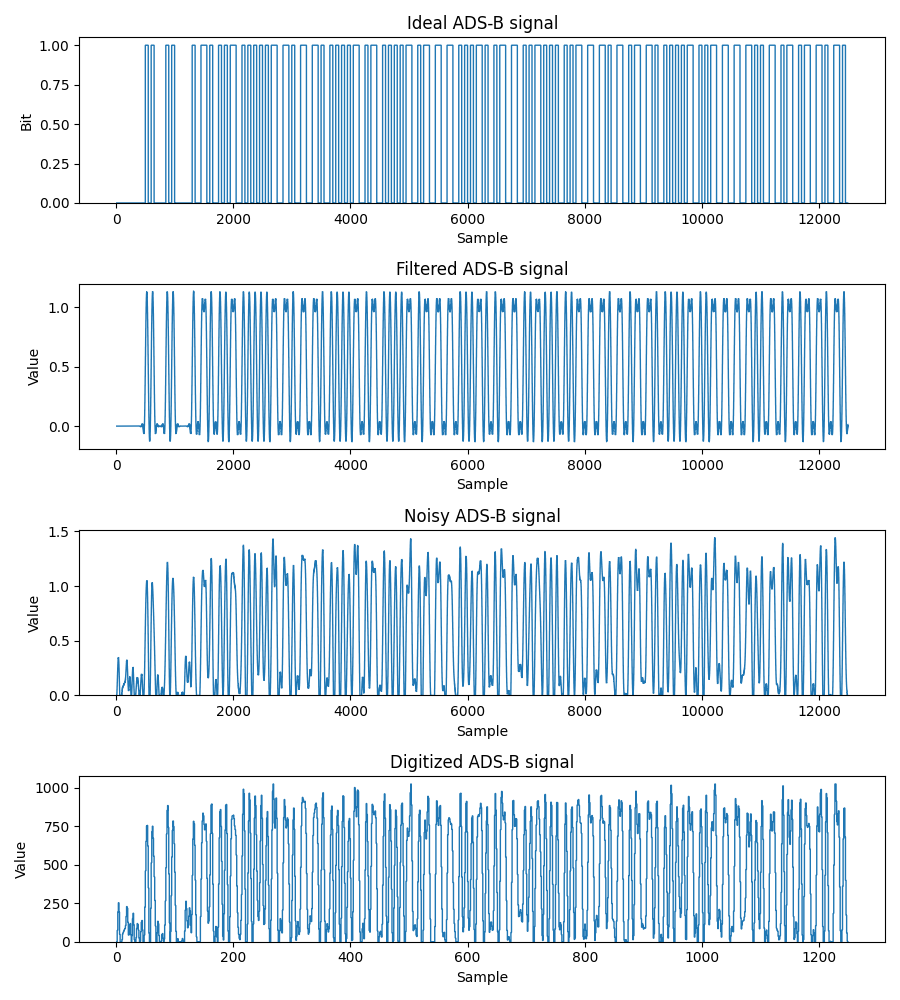

In [2]:
%matplotlib widget
# %matplotlib notebook
import math
import numpy as np
import matplotlib.pyplot as plt
from Functions.signal_generator import signal_start_pause_length, generate_ADSB, \
                                        digitize_signal, get_signal_energy, normalize_signal
from Functions.crc import generate_adsb_crc
from preambules_list import preambule_list, Preambule
from Functions.preambule_variant import Correlation

#Configuration
amplitude = 1
data_bits = bytes([0x8D, 0x40, 0x6B, 0x90, 0x20, 0x15, 0xA6, 0x78, 0xD4, 0xD2, 0x20])

#Generate and append CRC
crc_bits = generate_adsb_crc(data_bits)
full_bits = data_bits + crc_bits
print("Full bytes with CRC:")
for i in full_bits:
    print(hex(i) + " ", end='')

#Generate and plot simulated ADS-B
ideal_signal, filtered_signal, noisy_signal = generate_ADSB(amplitude, full_bits)
#Digitize signal
digitized_signal, digitized_t = digitize_signal(noisy_signal, 100E6, 10E6, 1.4, 2**10)

plt.figure(figsize=(9,10))
plt.subplot(4, 1, 1)
plt.stairs(ideal_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Bit')
plt.title('Ideal ADS-B signal')

plt.subplot(4, 1, 2)
plt.stairs(filtered_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Filtered ADS-B signal')

plt.subplot(4, 1, 3)
plt.stairs(noisy_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Noisy ADS-B signal')

plt.subplot(4, 1, 4)
plt.stairs(digitized_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Digitized ADS-B signal')
plt.tight_layout()
plt.subplots_adjust()
plt.show()



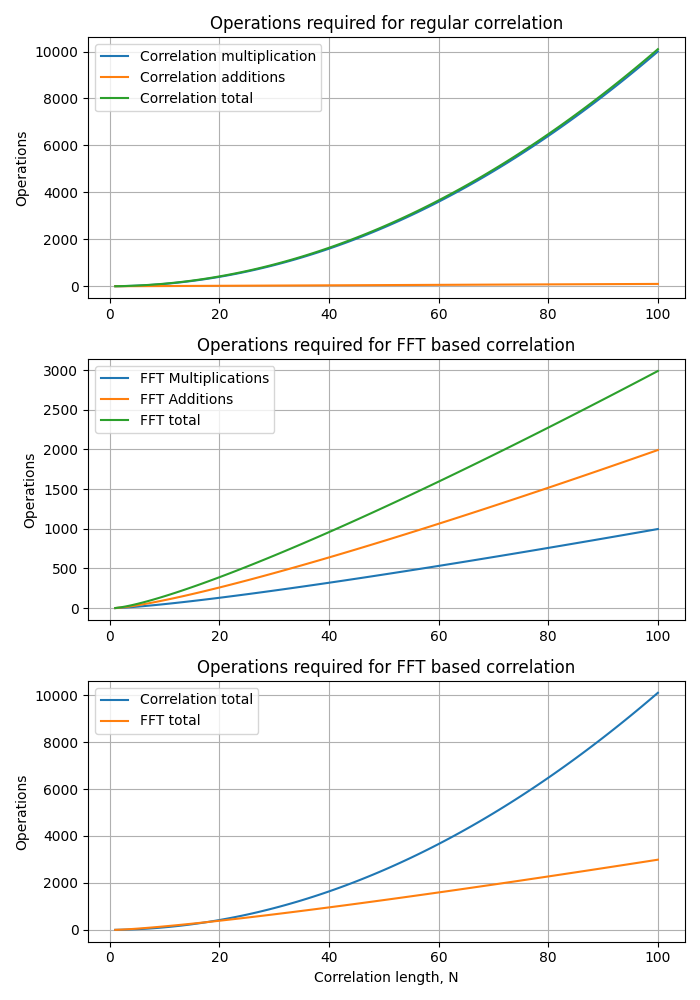

In [3]:
#Correlation with FFT effectiveness
N_values = np.linspace(1, 100, 100)
# Regular correlation
correlation_multiplications = [N**2 for N in N_values]
correlation_additions = [(N-1) for N in N_values]
# FFT based correlation
# Two FFT calculations and one IFFT
fft_multiplications = [(N/2 * math.log2(N) * 3) for N in N_values]
fft_additions = [(N* math.log2(N) * 3) for N in N_values]

correlation_total = [correlation_multiplications[i] + correlation_additions[i] for i in range(len(correlation_multiplications))]
fft_total = [fft_multiplications[i] + fft_additions[i] for i in range(len(fft_multiplications))]

plt.figure(figsize=(7,10))
plt.subplot(311)
plt.plot(N_values, correlation_multiplications, label="Correlation multiplication")
plt.plot(N_values, correlation_additions, label="Correlation additions")
plt.plot(N_values, correlation_total, label="Correlation total")
plt.ylabel("Operations")
plt.title("Operations required for regular correlation")
plt.grid()
plt.legend()
plt.subplot(312)
plt.plot(N_values, fft_multiplications, label="FFT Multiplications")
plt.plot(N_values, fft_additions, label="FFT Additions")
plt.plot(N_values, fft_total, label="FFT total")
plt.ylabel("Operations")
plt.title("Operations required for FFT based correlation")
plt.grid()
plt.legend()
plt.subplot(313)
plt.plot(N_values, correlation_total, label="Correlation total")
plt.plot(N_values, fft_total, label="FFT total")
plt.xlabel("Correlation length, N")
plt.ylabel("Operations")
plt.title("Operations required for FFT based correlation")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

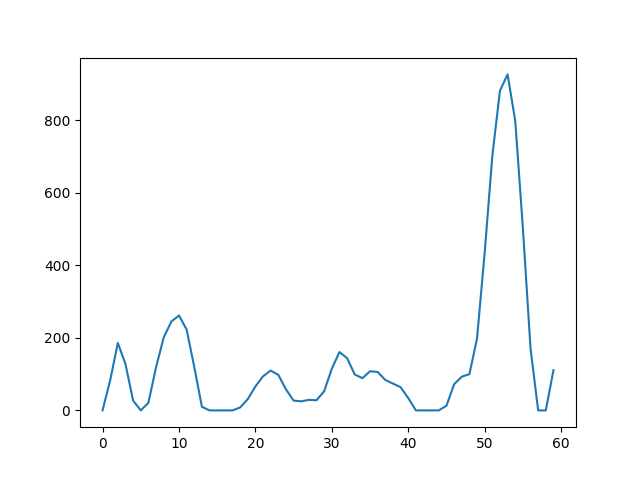

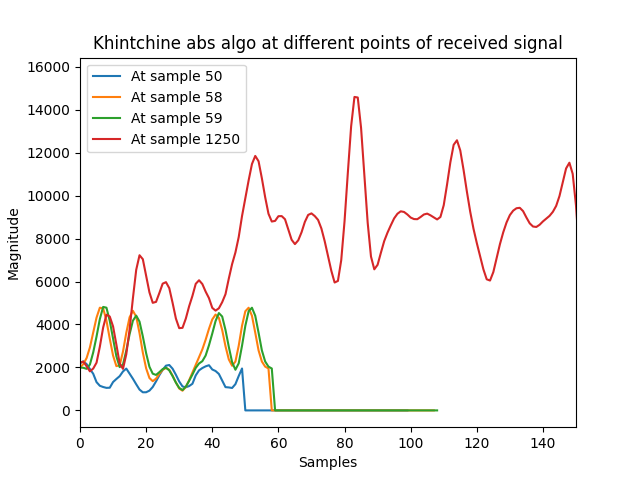

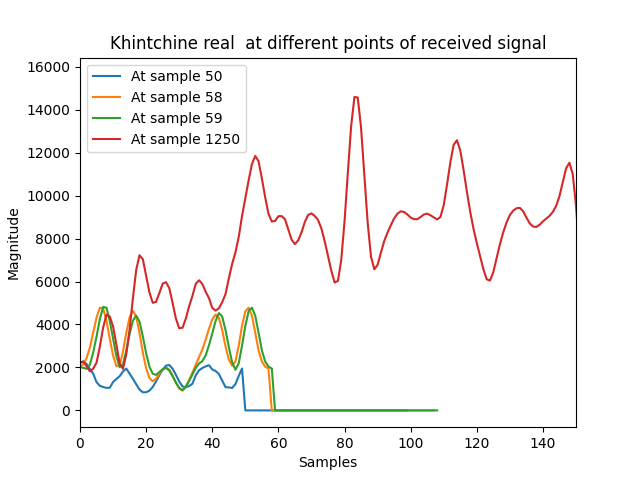

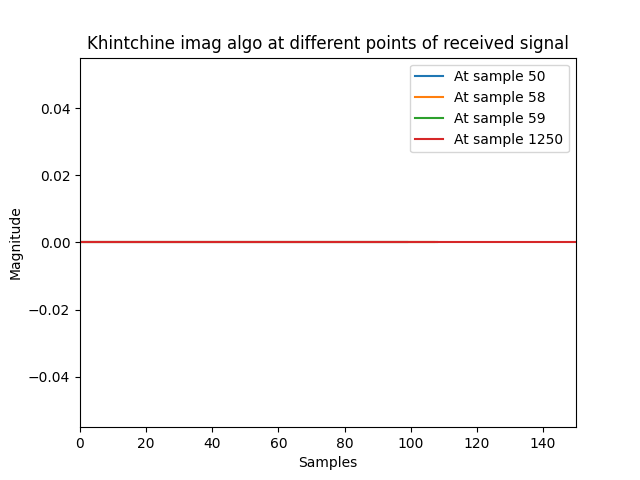

In [2]:
k_values = [50, 58, 59, len(digitized_signal)]
plt.figure()
plt.plot(digitized_signal[0:60])
plt.show()
plt.figure()
for k in k_values:
    corr_kir_k = preambule_list[0].get_correlation(digitized_signal[:k], Correlation.Khintchine)
    abs_corr = np.abs(corr_kir_k)
    plt.plot(abs_corr, label=f"At sample {str(k)}")
plt.xlim([0, k_values[0]*3])
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.title("Khintchine abs algo at different points of received signal")
plt.legend()
plt.show()

plt.figure()
for k in k_values:
    corr_kir_k = preambule_list[0].get_correlation(digitized_signal[:k], Correlation.Khintchine)
    abs_corr = np.real(corr_kir_k)
    plt.plot(abs_corr, label=f"At sample {str(k)}")
plt.xlim([0, k_values[0]*3])
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.title("Khintchine real  at different points of received signal")
plt.legend()
plt.show()

plt.figure()
for k in k_values:
    corr_kir_k = preambule_list[0].get_correlation(digitized_signal[:k], Correlation.Khintchine)
    abs_corr = np.imag(corr_kir_k)
    plt.plot(abs_corr, label=f"At sample {str(k)}")
plt.xlim([0, k_values[0]*3])
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.title("Khintchine imag algo at different points of received signal")
plt.legend()
plt.show()

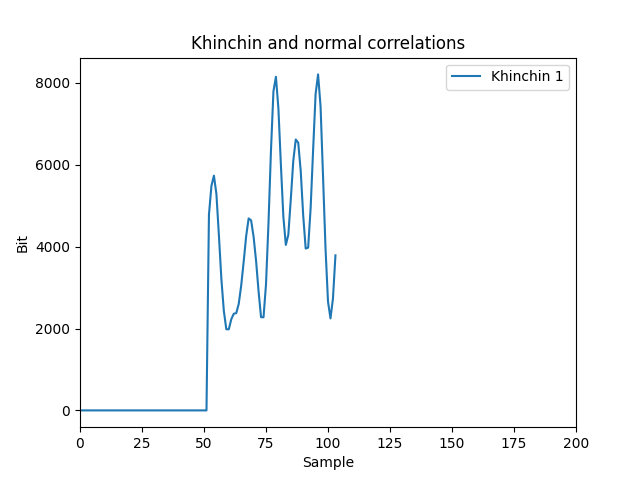

In [3]:
khin_range_start = 75
preambule = preambule_list[Preambule.IdealExpanded.value]
khin_length = len(preambule.get_coefficients())
corr_normal = preambule.get_correlation(digitized_signal, Correlation.Basic)
# Populate Khin samples
all_khin_samples = np.zeros((10, khin_length * 2))
for i in range(10):
    khin_signal = np.flip(digitized_signal[khin_range_start + i:khin_range_start + khin_length + i])
    corr_khintchine_1 = np.abs(preambule.get_correlation(khin_signal, Correlation.Khintchine))
    # corr_khintchin = np.concatenate((np.zeros(khin_range_start + 1), np.flip(corr_khintchine_1)))
    all_khin_samples[i, :] = np.flip(corr_khintchine_1)

# plt.figure()
fig, ax = plt.subplots()
# plt.plot(digitized_signal)
# plt.stairs(corr_normal, label="Normal")
# khin_plot, = plt.plot(corr_khintchin, label="Khinchin 1")
khin_plot, = plt.plot(all_khin_samples[1, :], label="Khinchin 1")
# plt.plot(corr_khintchine_2, label="Khinchin 2")
plt.title(preambule.get_name() + " preambule correlation")
plt.legend()
plt.xlim([0, 200])
plt.title("Khinchin and normal correlations")
plt.xlabel('Sample')
plt.ylabel('Bit')
# plt.show()

def update(frame):
#     # khin_range_offset = frame
#     # khin_signal = np.flip(digitized_signal[khin_range_start + khin_range_offset:khin_range_start + khin_range_offset + len(preambule.get_coefficients())])
#     # corr_khintchine_1 = np.abs(preambule.get_correlation(khin_signal, Correlation.Khintchine))
#     # corr_khintchin = np.concatenate((np.zeros(khin_range_start + khin_range_offset + 1), np.flip(corr_khintchine_1)))
    new_khinchin = np.concatenate((np.zeros(75 + 1 + frame), all_khin_samples[frame, :]))
    khin_plot.set_ydata(new_khinchin)
    return khin_plot,

# ani = FuncAnimation(fig, update, frames=np.arange(0, 3), blit=True)
plt.show()


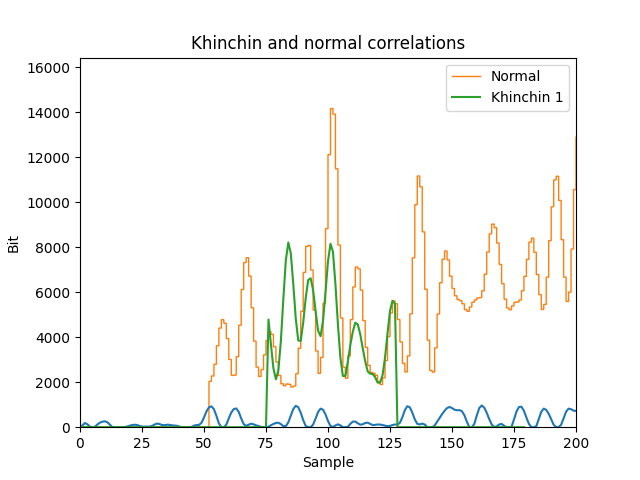

In [4]:
preambule = preambule_list[Preambule.IdealExpanded.value]
corr_normal = preambule.get_correlation(digitized_signal, Correlation.Basic)
khin_range_start = 75
khin_signal = np.flip(digitized_signal[khin_range_start:khin_range_start + len(preambule.get_coefficients())])
corr_khintchine_1 = preambule.get_correlation(khin_signal, Correlation.Khintchine)
corr_khintchin = np.concatenate((np.zeros(76), corr_khintchine_1))
# corr_khintchine_2 = np.abs(preambule.get_correlation(digitized_signal[signal_start_pause_length:signal_start_pause_length], Correlation.Khintchine))

# Correlation and energy plot
plt.figure()
plt.plot(digitized_signal)
plt.stairs(corr_normal, label="Normal")
plt.plot(corr_khintchin, label="Khinchin 1")
# plt.plot(corr_khintchine_2, label="Khinchin 2")
plt.title(preambule.get_name() + " preambule correlation")
plt.legend()
plt.xlim([0, 200])
plt.title("Khinchin and normal correlations")
plt.xlabel('Sample')
plt.ylabel('Bit')
plt.show()

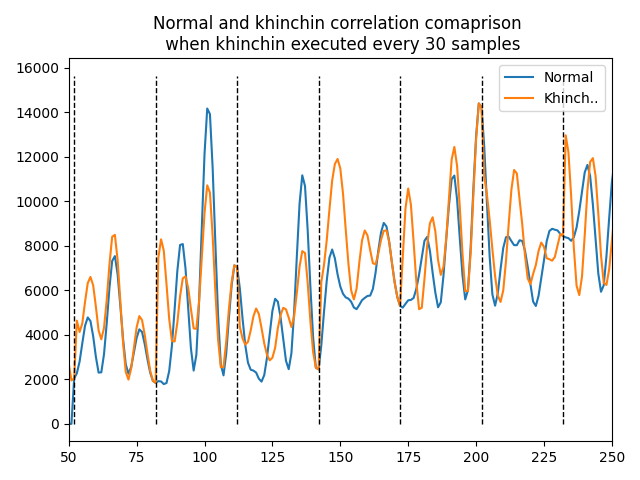

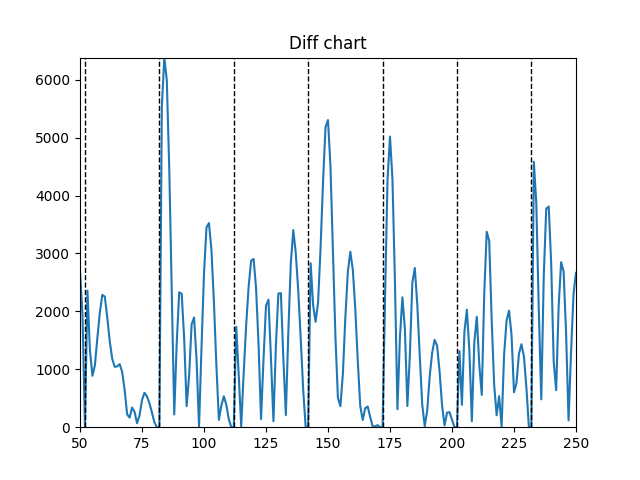

In [5]:

# Skip samples
kinchin_corr_samples = 30

preambule = preambule_list[Preambule.IdealExpanded.value]
corr_normal = preambule.get_correlation(digitized_signal, Correlation.Basic)
corr_kinchin = np.zeros(len(corr_normal))
vlines = []
for i in range(len(preambule.get_coefficients()), len(corr_kinchin), kinchin_corr_samples):
    khin_signal = np.flip(digitized_signal[i -  + len(preambule.get_coefficients()):i])
    temp_corr_khinchin = preambule.get_correlation(khin_signal, Correlation.Khintchine)
    temp_corr_khinchin = temp_corr_khinchin[0:(int(len(temp_corr_khinchin) / 2))]
    corr_kinchin[i-kinchin_corr_samples + 1:i + 1] = temp_corr_khinchin[len(temp_corr_khinchin) - kinchin_corr_samples : len(temp_corr_khinchin)]
    vlines.append(i)

diff_chart = np.zeros(len(corr_normal))
for i in range(len(diff_chart)):
    diff_chart[i] = np.abs(corr_normal[i] - corr_kinchin[i])

display_x_start = 50
display_x_range = 200

plt.figure()
plt.title(f"Normal and khinchin correlation comaprison \n when khinchin executed every {kinchin_corr_samples} samples")
plt.plot(corr_normal, label = "Normal")
plt.plot(corr_kinchin, label="Khinch..")
plt.vlines(x=vlines, ymin=0, ymax=max(corr_normal), color = 'black', linestyle='--', lw=1)
plt.legend()
plt.xlim([display_x_start, display_x_start + display_x_range])
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(diff_chart)
plt.title("Diff chart")
plt.xlim([display_x_start, display_x_start+display_x_range])
plt.vlines(x=vlines, ymin=0, ymax=max(diff_chart[0:display_x_range]), color = 'black', linestyle='--', lw=1)
plt.ylim([0, max(diff_chart[0: display_x_range])])
plt.show()

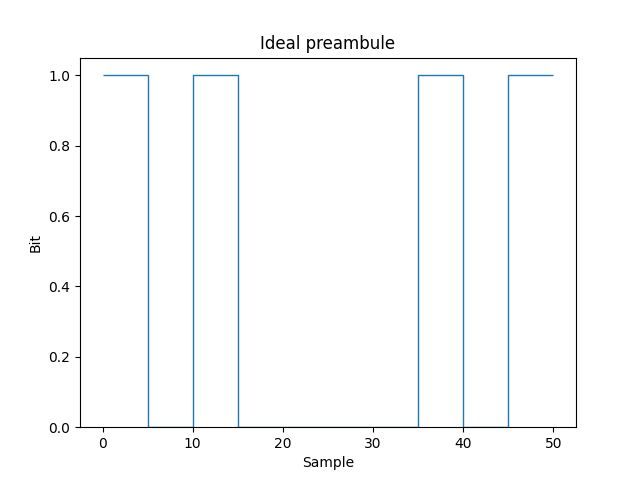

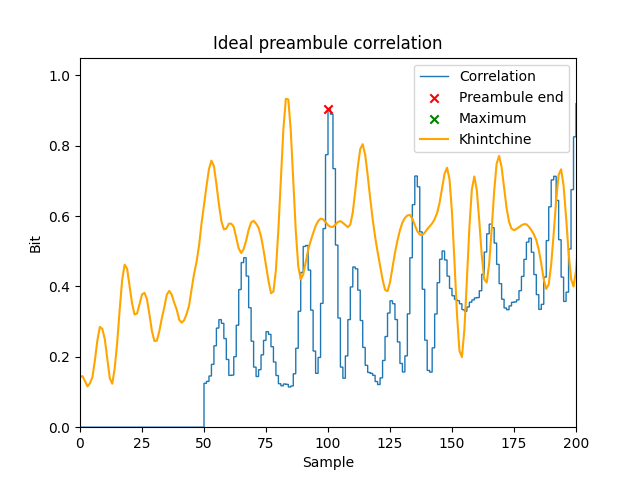

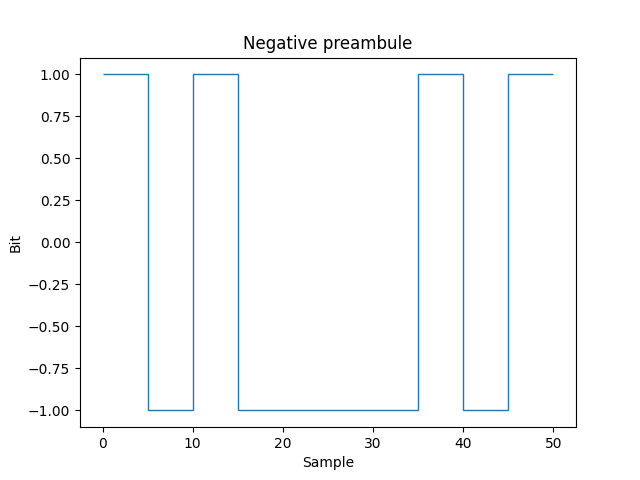

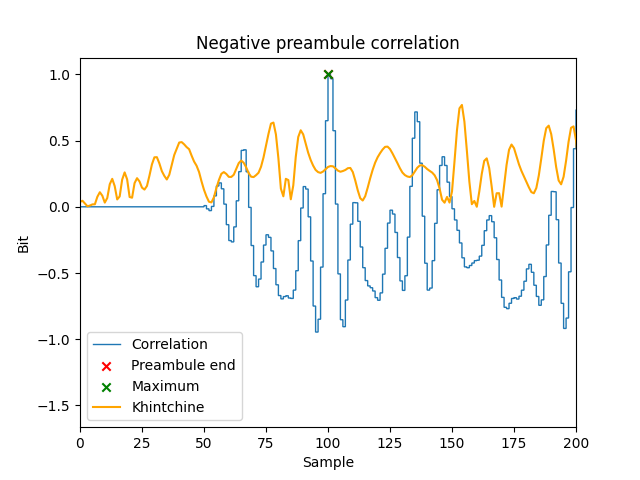

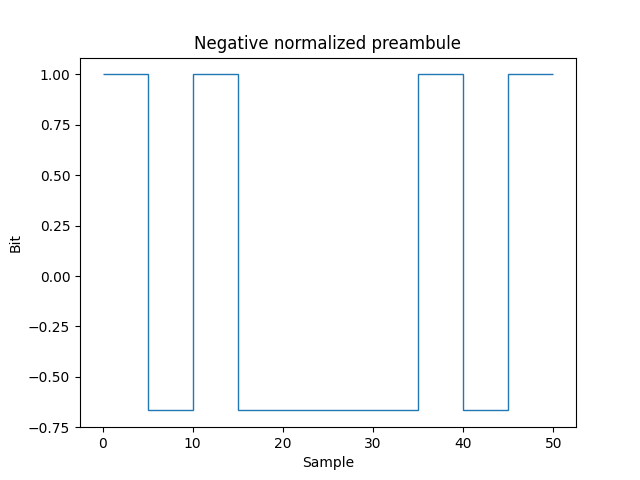

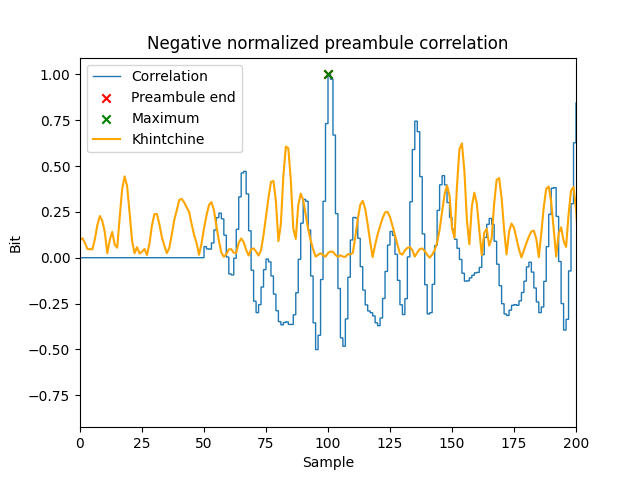

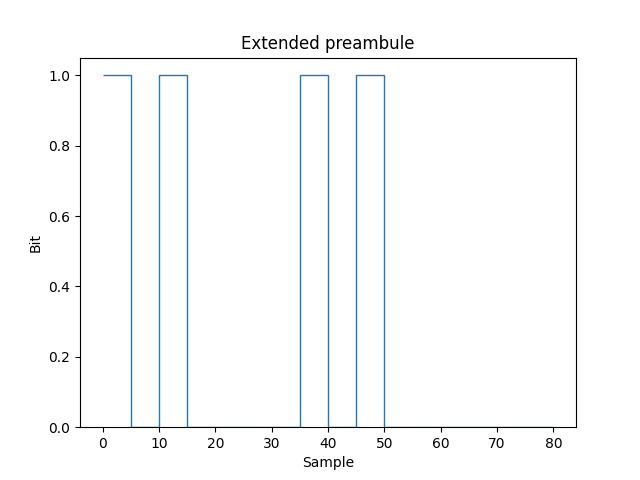

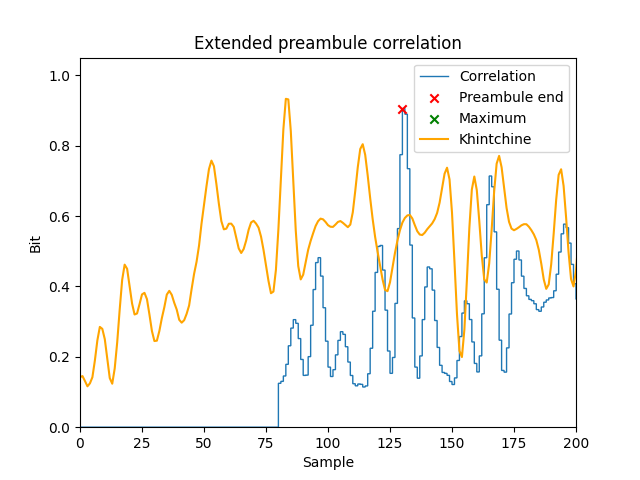

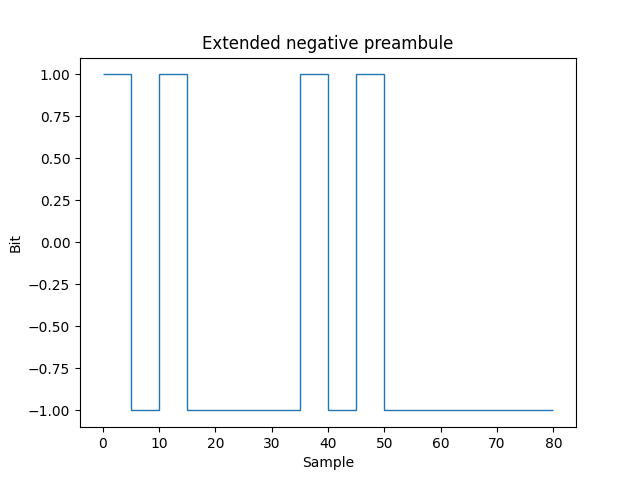

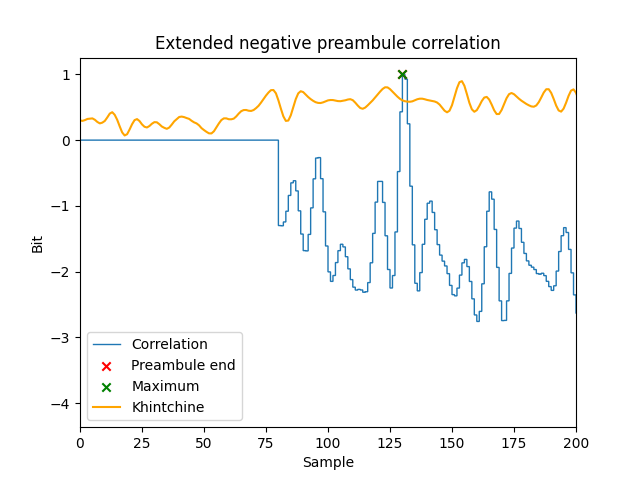

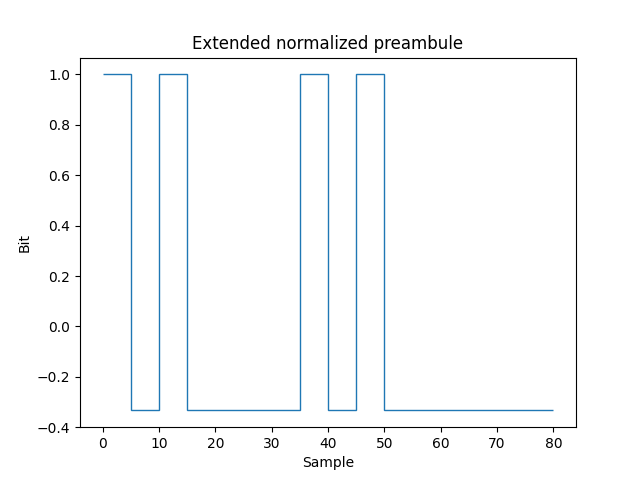

C:\Users\simon\AppData\Local\Temp\ipykernel_20956\3287215140.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


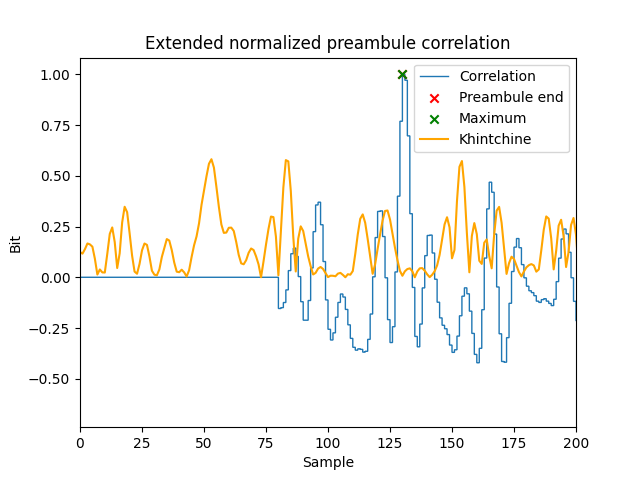

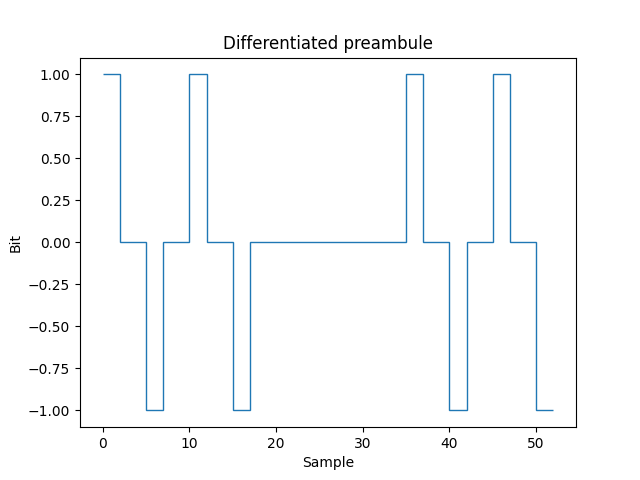

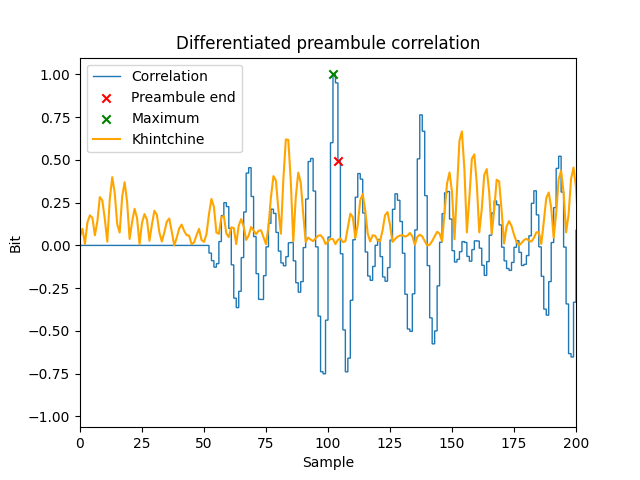

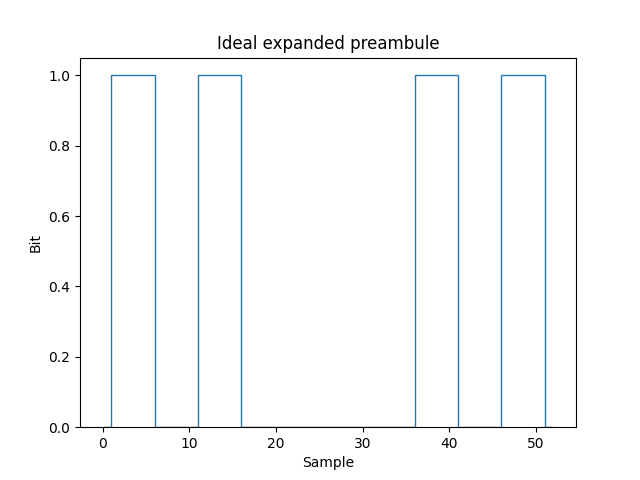

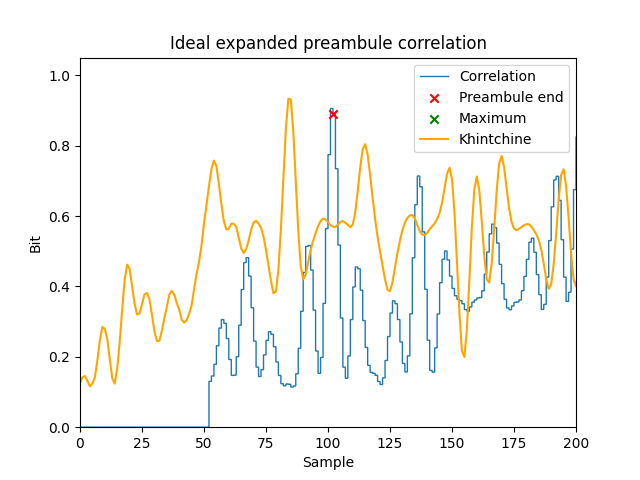

In [6]:

for preambule in preambule_list:
    curr_preambule_corr = preambule.get_correlation(digitized_signal, Correlation.Basic)
    curr_preambule_corr_khintchine = np.abs(preambule.get_correlation(digitized_signal, Correlation.Khintchine))
    curr_energy = get_signal_energy(digitized_signal, len(preambule.get_coefficients()))
    normalize_signal(curr_preambule_corr)
    normalize_signal(curr_preambule_corr_khintchine)
    max_idx = np.argmax(curr_preambule_corr)
    # Preambule plot
    plt.figure()
    plt.stairs(preambule.get_coefficients(), baseline=None)
    plt.xlabel('Sample')
    plt.ylabel('Bit')
    plt.title(preambule.get_name() + " preambule")
    plt.show()

    # Correlation and energy plot
    plt.figure()
    plt.stairs(curr_preambule_corr, label="Correlation", baseline=None)
    plt.scatter(signal_start_pause_length + preambule.get_expected_maximum(),
                curr_preambule_corr[signal_start_pause_length + preambule.get_expected_maximum()],
                marker='x', color='red', label="Preambule end")
    plt.scatter(max_idx, curr_preambule_corr[max_idx], marker='x', color='green', label="Maximum")
    plt.plot(curr_preambule_corr_khintchine, color='orange', label="Khintchine")
    plt.title(preambule.get_name() + " preambule correlation")
    plt.legend()
    plt.xlim([0, 200])

    plt.xlabel('Sample')
    plt.ylabel('Bit')
    plt.show()